In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm.notebook import tqdm
from IPython.display import clear_output
import dataframe_image as dfi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Sequential 
from keras import optimizers

from azure.storage.blob import BlobClient
from io import StringIO

## Data & preprocessing

In [2]:
constr = "DefaultEndpointsProtocol=https;AccountName=fysstk4155;AccountKey=uFpl4Qc0lIhE8bwHMH80mhsleq0kg7pW/TW8/KzsQY5+QULWfimUXuYasCBYXtID7BTfG98m6zGSJCxSFpdXvw==;BlobEndpoint=https://fysstk4155.blob.core.windows.net/;QueueEndpoint=https://fysstk4155.queue.core.windows.net/;TableEndpoint=https://fysstk4155.table.core.windows.net/;FileEndpoint=https://fysstk4155.file.core.windows.net/;"
blob = BlobClient.from_connection_string(constr, container_name="project3", blob_name="globalterrorismdb_0718dist.csv")
file = StringIO(blob.download_blob().content_as_text(encoding="latin1"))
df = pd.read_csv(file)

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# df = pd.read_csv("globalterrorismdb_0718dist.csv",encoding="latin1")

df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
df.shape

(181691, 135)

In [5]:
df_reduced = df[["iyear","imonth","iday","extended",
  "doubtterr","alternative","alternative_txt","multiple",
   "country","country_txt","region","region_txt","latitude","longitude","specificity",
    "attacktype1","attacktype1_txt","attacktype2","attacktype2_txt","attacktype3","attacktype3_txt","success","suicide",
    "weaptype1","weaptype1_txt","weapsubtype1","weapsubtype1_txt",
    "targtype1","targtype1_txt","targsubtype1","targsubtype1_txt","natlty1","natlty1_txt",
    "guncertain1","individual","nperps",
    "nkill","nwound","property","propvalue","ishostkid","nhostkid",
    "INT_LOG","INT_IDEO","INT_MISC" 
  ]]

In [6]:
df_reduced_txt = df_reduced[["alternative_txt","country_txt","region_txt",
                             "attacktype1_txt","attacktype2_txt","attacktype3_txt",
                             "weaptype1_txt","weapsubtype1_txt",
                             "targtype1_txt","targsubtype1_txt","natlty1_txt",
                             ]]

In [7]:
df_reduced = df_reduced.drop(df_reduced_txt.columns,axis=1)


In [8]:
df_reduced.shape

(181691, 34)

In [9]:
df_reduced.count().sort_values()

attacktype3        428
attacktype2       6314
nhostkid         13572
alternative      29011
propvalue        38989
nperps          110576
weapsubtype1    160923
nwound          165380
targsubtype1    171318
nkill           171378
longitude       177134
latitude        177135
natlty1         180132
guncertain1     181311
ishostkid       181513
specificity     181685
multiple        181690
doubtterr       181690
property        181691
individual      181691
INT_LOG         181691
iyear           181691
suicide         181691
weaptype1       181691
INT_IDEO        181691
success         181691
attacktype1     181691
region          181691
country         181691
extended        181691
iday            181691
imonth          181691
targtype1       181691
INT_MISC        181691
dtype: int64

Creating a new features for multiple attack types, 1 if more than one attack type else 0. \
Removes attacktype2 and attacktype3. 

In [10]:
df_reduced["multitypeattack"] = 0 
condition1 = df_reduced["attacktype2"].notna()
condition2 = df_reduced["attacktype3"].notna()
df_reduced.loc[condition1|condition2,"multitypeattack"] = 1 
df_reduced = df_reduced.drop(["attacktype2","attacktype3"],axis=1)

Sorting for incidents after 1997. \
Removing 3 features with a lot of missing values

In [11]:
df_reduced = df_reduced.loc[df_reduced.iyear > 1997]
df_reduced = df_reduced.drop(["nhostkid","alternative","propvalue"],axis=1)
df_reduced = df_reduced.drop("weapsubtype1",axis=1)
df_reduced = df_reduced.drop("targsubtype1",axis=1)

In [12]:
df_reduced.shape

(114184, 28)

Exploring still missing values

In [13]:
df_reduced.count().sort_values()[df_reduced.count().sort_values() != 114184] - 114184

nperps        -13166
nwound         -8232
nkill          -4280
natlty1        -1126
latitude        -934
longitude       -934
guncertain1     -380
specificity       -6
ishostkid         -3
doubtterr         -1
multiple          -1
dtype: int64

In [14]:
df_reduced[df_reduced.count().sort_values()[df_reduced.count().sort_values() != 114184].index]

,nperps,nwound,nkill,natlty1,latitude,longitude,guncertain1,specificity,ishostkid,doubtterr,multiple
67507,100.0,6.0,104.0,34.0,-3.375828,29.364107,0.0,1.0,0.0,1.0,0.0
67508,NaN,3.0,0.0,167.0,55.751377,37.579914,0.0,1.0,0.0,0.0,0.0
67509,NaN,0.0,1.0,233.0,54.607712,-5.956210,0.0,1.0,0.0,0.0,0.0
67510,NaN,0.0,0.0,999.0,33.303566,44.371773,0.0,1.0,0.0,0.0,0.0
67511,NaN,1.0,0.0,97.0,31.995965,35.271110,0.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
181686,-99.0,2.0,1.0,182.0,2.359673,45.385034,0.0,2.0,0.0,1.0,0.0
181687,-99.0,7.0,2.0,167.0,35.407278,35.942679,0.0,1.0,0.0,1.0,0.0
181688,-99.0,0.0,0.0,160.0,6.900742,124.437908,0.0,2.0,0.0,0.0,0.0
181689,-99.0,0.0,0.0,92.0,24.798346,93.940430,0.0,1.0,0.0,0.0,0.0


In [15]:
df_reduced["nperps"] = df_reduced["nperps"].fillna(-99)
df_reduced["nwound"] = df_reduced["nwound"].fillna(-99)
df_reduced["nkill"] = df_reduced["nkill"].fillna(-99)
df_reduced["natlty1"] = df_reduced["natlty1"].fillna(-99)

In [16]:
df_reduced = df_reduced.drop(df_reduced[df_reduced.longitude.isna()].index,axis=0)
df_reduced = df_reduced.drop(df_reduced[df_reduced.guncertain1.isna()].index,axis=0)
df_reduced = df_reduced.drop(df_reduced[df_reduced.ishostkid.isna()].index,axis=0)
df_reduced = df_reduced.drop(df_reduced[df_reduced.doubtterr.isna()].index,axis=0)
df_reduced = df_reduced.drop(df_reduced[df_reduced.multiple.isna()].index,axis=0)

In [17]:
df_reduced.count()

iyear              112874
imonth             112874
iday               112874
extended           112874
doubtterr          112874
multiple           112874
country            112874
region             112874
latitude           112874
longitude          112874
specificity        112874
attacktype1        112874
success            112874
suicide            112874
weaptype1          112874
targtype1          112874
natlty1            112874
guncertain1        112874
individual         112874
nperps             112874
nkill              112874
nwound             112874
property           112874
ishostkid          112874
INT_LOG            112874
INT_IDEO           112874
INT_MISC           112874
multitypeattack    112874
dtype: int64

In [18]:
df_reduced.shape

(112874, 28)

In [19]:
df_reduced.corr()["extended"].sort_values()

nkill             -0.277864
nwound            -0.171253
latitude          -0.075638
suicide           -0.052701
longitude         -0.038379
doubtterr         -0.036306
multiple          -0.016474
individual        -0.013167
iday              -0.005702
country           -0.000358
imonth             0.000033
region             0.006090
nperps             0.007327
iyear              0.011122
targtype1          0.015964
natlty1            0.018302
guncertain1        0.032002
property           0.039994
INT_MISC           0.042581
specificity        0.057821
success            0.091885
INT_LOG            0.115690
INT_IDEO           0.116492
multitypeattack    0.198926
weaptype1          0.236317
ishostkid          0.300626
attacktype1        0.312881
extended           1.000000
Name: extended, dtype: float64

In [20]:
target = df_reduced["extended"]
features = df_reduced.drop("extended",axis=1)

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = np.array(target)
y = y.reshape(-1,1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
print("X_train:{} X_test:{}\ny_train:{} y_test:{}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train:(90299, 27) X_test:(22575, 27)
y_train:(90299, 1) y_test:(22575, 1)


## Neural Network

In [24]:
def neural_network(n_neurons,n_output,  eta, lmbd):
    model = Sequential()
#     model.add(Flatten())
    model.add(Dense(n_neurons[0], activation = "relu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[1], activation="relu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_output, activation="softmax"))
    
    sgd = keras.optimizers.SGD(lr=eta)
    model.compile(optimizer=sgd,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

### Neural network model 1

In [54]:
batch_size = 10000
epochs = 10 

eta_vals = np.logspace(-5,1,10)
lmbd_vals = np.logspace(-5,1,9)
lmbd_vals = np.insert(lmbd_vals,0,0)
result = np.zeros((len(eta_vals),len(lmbd_vals)),dtype=object)
train_accuracy = np.zeros((len(eta_vals),len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals),len(lmbd_vals)))

for i in tqdm(range(len(eta_vals))):
    for j in tqdm(range(len(lmbd_vals))):
        NN = neural_network([100,50],2 , eta_vals[i], lmbd_vals[j])
        
        NN.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,verbose=0)

        train_accuracy[i][j] = NN.evaluate(X_train, y_train,verbose=0)[1]
        test_accuracy[i][j] = NN.evaluate(X_test, y_test,verbose=0)[1]
        


In [26]:
eta_vals.round(3)

array([0.000e+00, 0.000e+00, 0.000e+00, 1.000e-03, 5.000e-03, 2.200e-02,
       1.000e-01, 4.640e-01, 2.154e+00, 1.000e+01])

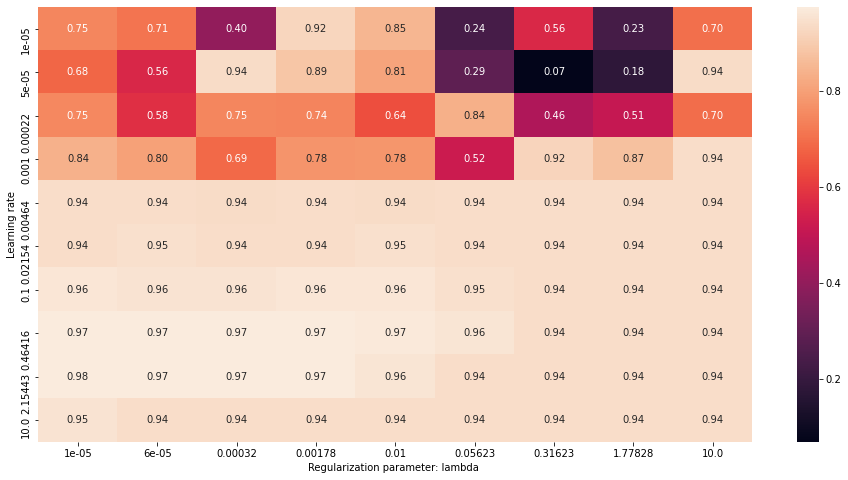

In [27]:
plt.figure(figsize=(16,8))
sns.heatmap(train_accuracy,
            yticklabels=eta_vals.round(5),
            xticklabels=lmbd_vals.round(5),
            fmt=".2f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/NNClass1.png")

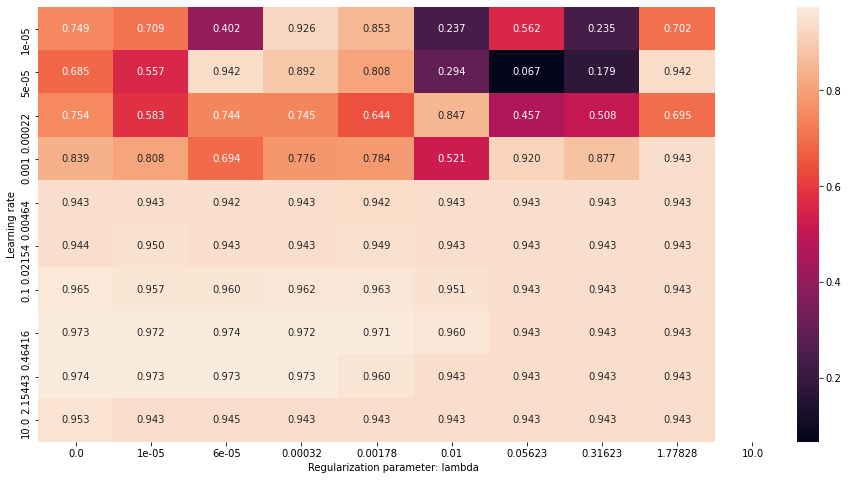

In [52]:
plt.figure(figsize=(16,8))
sns.heatmap(test_accuracy,
            yticklabels=eta_vals.round(5),
            xticklabels=lmbd_vals.round(5),
            fmt=".3f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/NNClass2.png")

In [53]:
test_accuracy.max()

0.9741306900978088

### Neural network model 2

In [29]:
def neural_network2(n_neurons,n_output,  eta, lmbd):
    model = Sequential()
#     model.add(Flatten())
    model.add(Dense(n_neurons[0], activation = "elu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[1], activation="elu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_output, activation="softmax"))
    
    sgd = keras.optimizers.SGD(lr=eta)
    model.compile(optimizer=sgd,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

In [30]:
batch_size = 10000
epochs = 10 

eta_vals = np.logspace(-5,1,10)
lmbd_vals = np.logspace(-5,1,9)

result = np.zeros((len(eta_vals),len(lmbd_vals)),dtype=object)
train_accuracy2 = np.zeros((len(eta_vals),len(lmbd_vals)))
test_accuracy2 = np.zeros((len(eta_vals),len(lmbd_vals)))

for i in tqdm(range(len(eta_vals))):
    for j in tqdm(range(len(lmbd_vals))):
        NN = neural_network2([100,50],2 , eta_vals[i], lmbd_vals[j])
        
        NN.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,verbose=0)

        train_accuracy2[i][j] = NN.evaluate(X_train, y_train,verbose=0)[1]
        test_accuracy2[i][j] = NN.evaluate(X_test, y_test,verbose=0)[1]
        


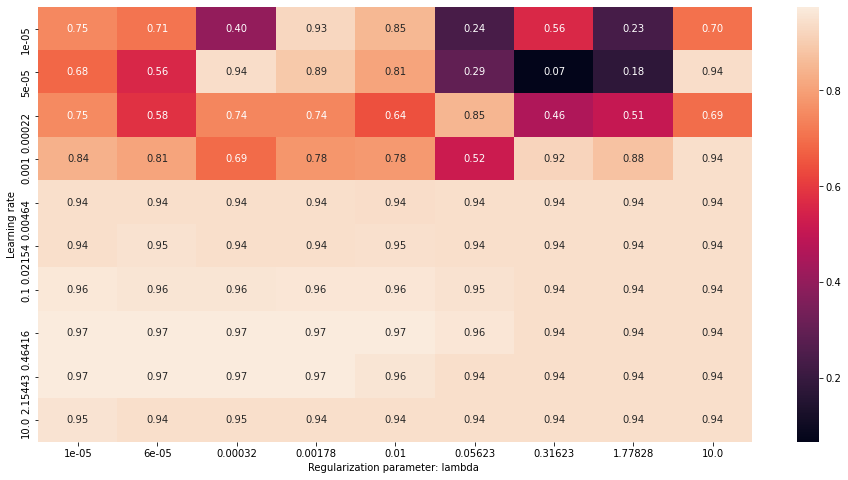

In [31]:
plt.figure(figsize=(16,8))
sns.heatmap(test_accuracy2,
            yticklabels=eta_vals.round(5),
            xticklabels=lmbd_vals.round(5),
            fmt=".2f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/NNClass3.png")

In [33]:
pd.DataFrame(test_accuracy2).max().max()

0.9735991358757019

In [32]:
pd.DataFrame(test_accuracy).max().max()

0.9741306900978088

### Neural network model 3

In [34]:
def neural_network3(n_neurons,n_output,  eta, lmbd):
    model = Sequential()
#     model.add(Flatten())
    model.add(Dense(n_neurons[0], activation = "relu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[0], activation = "relu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[1], activation="relu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_output, activation="softmax"))
    
    sgd = keras.optimizers.SGD(lr=eta)
    model.compile(optimizer=sgd,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

In [36]:
batch_size = 5000
epochs = 20 

eta_vals = np.logspace(-5,1,10)
lmbd_vals = np.logspace(-5,1,9)
lmbd_vals = np.insert(lmbd_vals,0,0)

train_accuracy3 = np.zeros((len(eta_vals),len(lmbd_vals)))
test_accuracy3 = np.zeros((len(eta_vals),len(lmbd_vals)))

for i in tqdm(range(len(eta_vals))):
    for j in tqdm(range(len(lmbd_vals))):
        NN = neural_network3([250,100,50],2 , eta_vals[i], lmbd_vals[j])
        
        NN.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,verbose=0)

#         train_accuracy3[i][j] = NN.evaluate(X_train, y_train,verbose=0)[1]
        test_accuracy3[i][j] = NN.evaluate(X_test, y_test,verbose=0)[1]
        


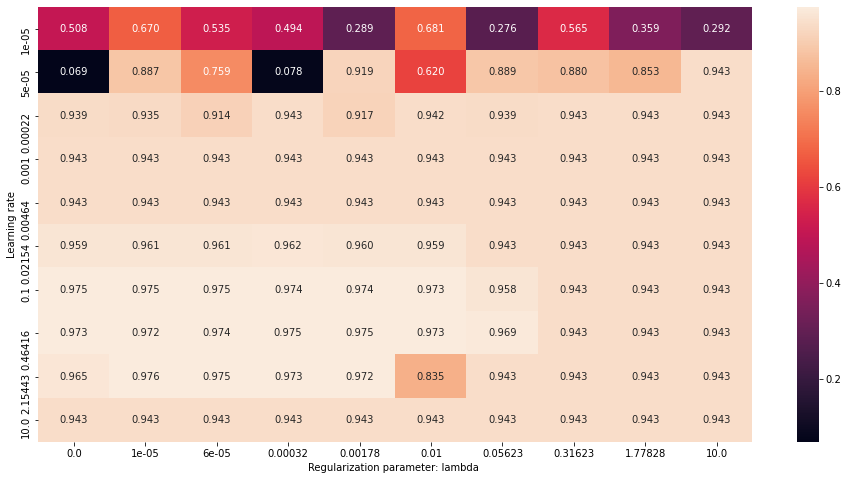

In [48]:
plt.figure(figsize=(16,8))
sns.heatmap(test_accuracy3,
            yticklabels=eta_vals.round(5),
            xticklabels=lmbd_vals.round(5),
            fmt=".3f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/NNClass4.png")

In [47]:
test_accuracy3.max().max()

0.9756367802619934

### Neural network model 4

In [40]:
def neural_network4(n_neurons,n_output,  eta, lmbd):
    model = Sequential()
#     model.add(Flatten())
    model.add(Dense(n_neurons[0], activation = "elu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[0], activation = "elu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_neurons[1], activation="elu", kernel_regularizer=keras.regularizers.l2(lmbd)))
    model.add(Dense(n_output, activation="softmax"))
    
    sgd = keras.optimizers.SGD(lr=eta)
    model.compile(optimizer=sgd,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

In [41]:
batch_size = 5000
epochs = 20 

eta_vals = np.logspace(-5,1,10)
lmbd_vals = np.logspace(-5,1,9)
lmbd_vals = np.insert(lmbd_vals,0,0)

train_accuracy4 = np.zeros((len(eta_vals),len(lmbd_vals)))
test_accuracy4 = np.zeros((len(eta_vals),len(lmbd_vals)))

for i in tqdm(range(len(eta_vals))):
    for j in tqdm(range(len(lmbd_vals))):
        NN = neural_network4([250,100,50],2 , eta_vals[i], lmbd_vals[j])
        
        NN.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,verbose=0)

#         train_accuracy3[i][j] = NN.evaluate(X_train, y_train,verbose=0)[1]
        test_accuracy4[i][j] = NN.evaluate(X_test, y_test,verbose=0)[1]
        


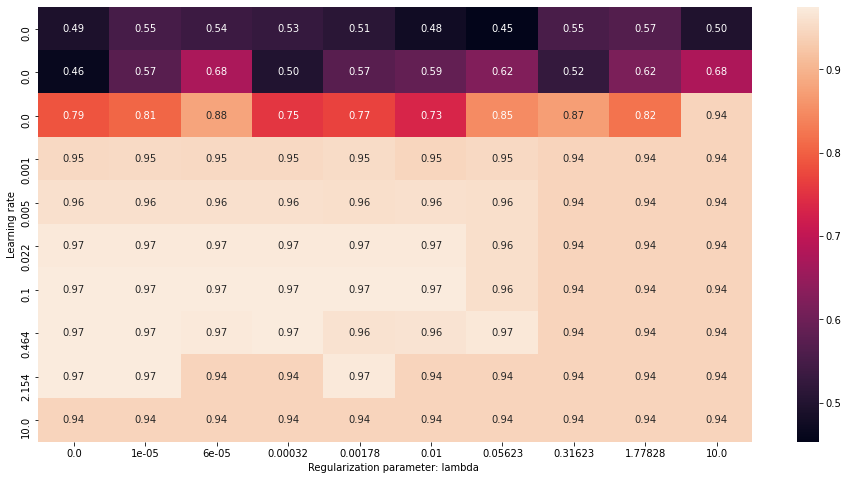

In [57]:
plt.figure(figsize=(16,8))
sns.heatmap(test_accuracy4,
            yticklabels=eta_vals.round(3),
            xticklabels=lmbd_vals.round(5),
            fmt=".2f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/NNClass5.png")

In [46]:
print(test_accuracy.max())
print(test_accuracy2.max())
print(test_accuracy3.max())
print(test_accuracy4.max())

0.9741306900978088
0.9735991358757019
0.9756367802619934
0.974750816822052


In [ ]:
l = []
l2 = [test_accuracy,test_accuracy2,test_accuracy3,test_accuracy4]
for i in l2:
    

In [66]:
min_ = pd.DataFrame([test_accuracy.min(),test_accuracy2.min(),test_accuracy3.min(),test_accuracy4.min()], columns=["min"])
max_ = pd.DataFrame([test_accuracy.max(),test_accuracy2.max(),test_accuracy3.max(),test_accuracy4.max()], columns=["max"])
mean_ = pd.DataFrame([test_accuracy.mean(),test_accuracy2.mean(),test_accuracy3.mean(),test_accuracy4.mean()], columns=["mean"])

In [76]:
df = pd.concat([min_,max_,mean_],axis=1)
df.index = df.index +1
df

,min,max,mean
1,0.100687,0.974042,0.817498
2,0.336390,0.973599,0.801378
3,0.068793,0.975637,0.874774
4,0.453200,0.974751,0.860120


In [78]:
dfi.export(df,"Tex/Figures/NNmodels.png")

## Suport Vector Machines Classification

In [81]:
svm1_result = np.zeros((len(eta_vals),len(lmbd_vals)))
for i in tqdm(range(len(eta_vals))):
    for j in range(len(lmbd_vals)):
        
        svm = SGDClassifier(loss="hinge",learning_rate="constant", eta0=eta_vals[i],alpha=lmbd_vals[j])
        svm.fit(X_train,y_train.ravel())
        svm1_result[i][j] = svm.score(X_test,y_test.ravel())

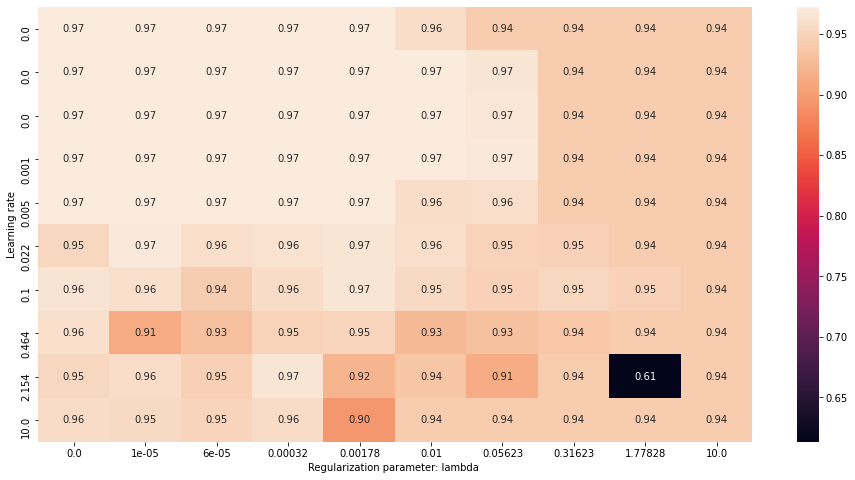

In [82]:
plt.figure(figsize=(16,8))
sns.heatmap(svm1_result,
            yticklabels=eta_vals.round(3),
            xticklabels=lmbd_vals.round(5),
            fmt=".2f",
            annot=True)
plt.ylabel("Learning rate")
plt.xlabel("Regularization parameter: lambda ")
plt.savefig("Tex/Figures/SGDClass.png")

In [83]:
svm1_result.max()

0.9724031007751938

In [57]:
C_vals = np.linspace(0.1,2,10)
svm2_results = np.zeros(len(C_vals))
i=0
for c in tqdm(C_vals):
    svm = LinearSVC(C=c, loss="hinge",max_iter=2000)
    svm.fit(X_train,y_train.ravel())
    svm2_results[i] = svm.score(X_test,y_test.ravel())
    
    i += 1 

c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

c:\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


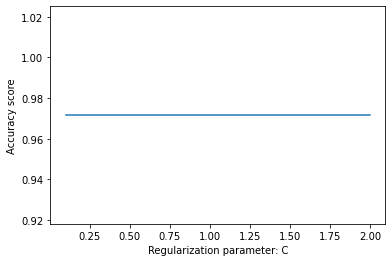

In [59]:
plt.plot(C_vals,svm2_results)
plt.xlabel("Regularization parameter: C")
plt.ylabel("Accuracy score")
plt.savefig("Tex/Figures/LinearSVC.png")

In [60]:
svm2_results

array([0.97165006, 0.97165006, 0.97165006, 0.97165006, 0.97165006,
       0.97165006, 0.97165006, 0.97165006, 0.97165006, 0.97165006])

In [ ]:
C_vals = np.linspace(0.01,5,10)
gamma_vals = np.linspace(0.01,5,10)

svm3_results = np.zeros((len(C_vals),len(gamma_vals)))
X_train_ = X_train[:len(X_train)//2]
y_train_ = y_train[:len(X_train)//2]
for i in tqdm(range(len(C_vals))):
    for j in tqdm(range(len(gamma_vals))):
        
        svm3 = SVC(kernel="linear",gamma=gamma_vals[j], C=C_vals[i],verbose=1)
        svm3.fit(X_train,y_train.ravel())
        svm3_results[i][j] = svm3.score(X_test,y_test.ravel())

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]